In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import v2
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
import wandb
wandb.login()

In [3]:
!export WANDB_INIT_TIMEOUT=120

In [ ]:
wandb.init(
    # set the wandb project where this run will be logged
    project="DDPM-1",

    # track hyperparameters and run metadata
    config={
    "noise_std": 0.5,
    "architecture": "CNN",
    "dataset": "Oxford-flowers",
    "epochs": 50,
    }
)

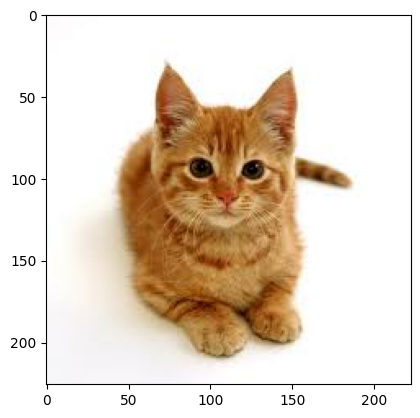

In [157]:
img = Image.open('cat1.jpeg')
plt.imshow(img)

In [158]:
imgToTensor = v2.PILToTensor()
tensorConvertFloat = v2.ToDtype(torch.float32, scale=True)
img_tensor = imgToTensor(img)
img_tensor = tensorConvertFloat(img_tensor)
tensorToImg = v2.ToPILImage()

In [159]:
def add_noise(good_image, noise_std, time_step):
    return good_image + noise_std * torch.randn_like(good_image) * np.sqrt(time_step)


In [160]:
noised_imgs = []

In [161]:
def forward_diffusion(time_steps, orig_img):
    for t in range(time_steps):
        noised_image = add_noise(orig_img, 0.1, t)
        noised_imgs.append(tensorToImg(noised_image))

In [162]:
forward_diffusion(15, img_tensor)

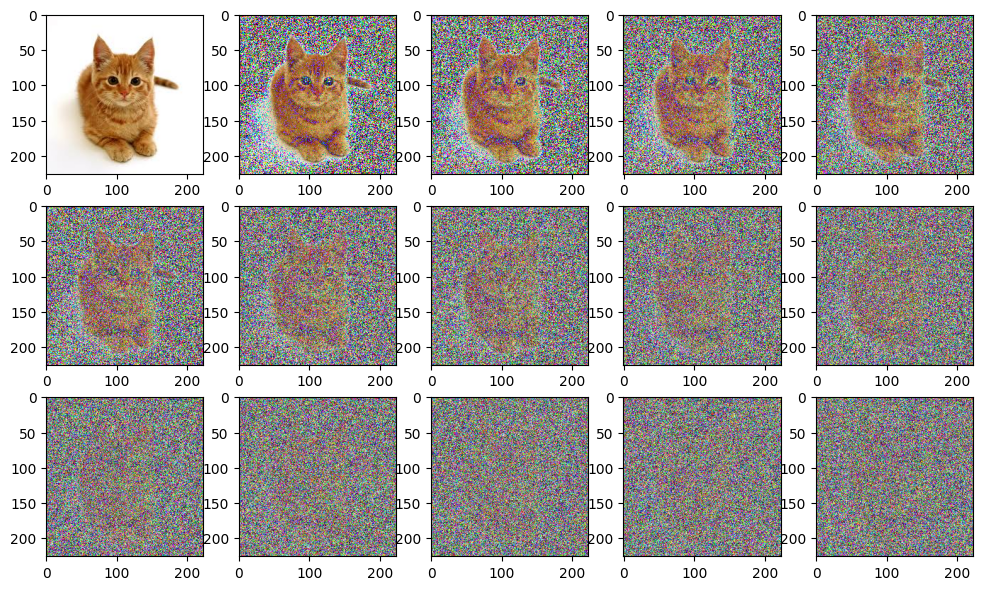

In [163]:
plt.figure(figsize=(12,12)) # specifying the overall grid size

for i in range(15):
    plt.subplot(5,5,i+1)    # the number of images in the grid is 5*5 (25)
    plt.imshow(noised_imgs[i])

plt.show()

In [165]:
def forward_diffusion(time_steps, orig_img):
    for t in range(time_steps):
        noised_image = add_noise(orig_img, 0.1, t)
        noised_imgs.append(tensorToImg(noised_image))

In [46]:
class DiffusionModel(nn.Module):
    def __init__(self):
        super(DiffusionModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 32, 3, padding=1)
        self.conv4 = nn.Conv2d(32, 3, 3, padding=1)
        
    def forward(self, x, t):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.conv4(x)
        return x


In [47]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

batch_size = 32

transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
flowers = datasets.Flowers102(root='./data', download=True, transform=transform)
dataloader = DataLoader(flowers, batch_size=batch_size, shuffle=True)

train_size = int(0.8 * len(flowers))
val_size = len(flowers) - train_size
train_dataset, val_dataset = random_split(flowers, [train_size, val_size])

def forward_diffusion(x, t, noise_std):
    return x + noise_std * torch.randn_like(x, device='mps') * torch.sqrt(t)


In [48]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [49]:
import torch.optim as optim

device = 'mps'

model = DiffusionModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

num_epochs = 50
noise_std = 0.5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        
        t = torch.rand(data.size(0), 1, 1, 1, device=device) 
        noisy_data = forward_diffusion(data, t, noise_std)
    
        optimizer.zero_grad()
        predicted_noise = model(noisy_data, t)
        
        true_noise = (noisy_data - data) / (noise_std * torch.sqrt(t))
        loss = criterion(predicted_noise, true_noise)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        wandb.log({"Batch Loss": loss.item()})
    avg_epoch_loss = running_loss / len(dataloader)
    wandb.log({"Epoch": epoch + 1, "Train_Loss": avg_epoch_loss})

    
    print(f'Epoch {epoch+1}, Train_Loss: {running_loss/len(train_loader)}')

    model.eval()
    running_loss = 0.0
    for data, target in val_loader:
        with torch.no_grad():
            data, target = data.to(device), target.to(device)
        
            # reconstructed_noise = model(noisy_data, t)
            # denoised_data = noisy_data - noise_std * reconstructed_noise * torch.sqrt(t)
            t = torch.rand(data.size(0), 1, 1, 1, device=device) 
            noisy_data = forward_diffusion(data, t, noise_std)
        
            optimizer.zero_grad()
            predicted_noise = model(noisy_data, t)
            
            true_noise = (noisy_data - data) / (noise_std * torch.sqrt(t))
            denoised_data = noisy_data - noise_std * predicted_noise * torch.sqrt(t)
            loss = criterion(predicted_noise, true_noise)
            running_loss += loss.item()
        original_images = data.permute(0, 2, 3, 1).cpu().numpy()
        noisy_images = noisy_data.permute(0, 2, 3, 1).cpu().numpy()
        denoised_images = (noisy_data - noise_std * predicted_noise * torch.sqrt(t)).permute(0, 2, 3, 1).cpu().numpy()
    
        
        wandb.log({
        "Original Image": [wandb.Image(original_images[i]) for i in range(5)],
        "Noisy Image": [wandb.Image(noisy_images[i]) for i in range(5)],
        "Denoised Image": [wandb.Image(denoised_images[i]) for i in range(5)],
    })

    avg_epoch_loss = running_loss / len(val_loader)
    wandb.log({"Epoch": epoch + 1, "Val_Loss": avg_epoch_loss})
    print(f'Epoch {epoch+1}, Val_Loss: {avg_epoch_loss}')
    
wandb.finish()

Epoch 1, Train_Loss: 0.7316083587132968
Epoch 1, Val_Loss: 0.374823591538838
Epoch 2, Train_Loss: 0.27111374472196287
Epoch 2, Val_Loss: 0.1974522726876395
Epoch 3, Train_Loss: 0.16090179865176862
Epoch 3, Val_Loss: 0.15600853732654027
Epoch 4, Train_Loss: 0.15146875696686599
Epoch 4, Val_Loss: 0.13022024823086603
Epoch 5, Train_Loss: 0.13037854776932642
Epoch 5, Val_Loss: 0.10388948555503573
Epoch 6, Train_Loss: 0.12767275852652696
Epoch 6, Val_Loss: 0.12261031993797847
Epoch 7, Train_Loss: 0.12899806149877036
Epoch 7, Val_Loss: 0.10878280656678337
Epoch 8, Train_Loss: 0.11577660791002788
Epoch 8, Val_Loss: 0.10420046427420207
Epoch 9, Train_Loss: 0.10836932607568227
Epoch 9, Val_Loss: 0.10496722055333
Epoch 10, Train_Loss: 0.103279181684439
Epoch 10, Val_Loss: 0.10626235817159925
Epoch 11, Train_Loss: 0.10198294457334739
Epoch 11, Val_Loss: 0.09457000025681087
Epoch 12, Train_Loss: 0.10399699153808448
Epoch 12, Val_Loss: 0.09150270798376628
Epoch 13, Train_Loss: 0.09589738570726834
E

Batch Loss,█▄▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Train_Loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val_Loss,█▄▃▃▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Batch Loss,0.04801
Epoch,50
Train_Loss,0.05101
Val_Loss,0.06028


In [50]:
import matplotlib.pyplot as plt

def visualize_samples(original, noisy, denoised):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(original.squeeze(), cmap='gray')
    ax[0].set_title('Original')
    ax[0].axis('off')
    
    ax[1].imshow(noisy.squeeze(), cmap='gray')
    ax[1].set_title('Noisy')
    ax[1].axis('off')
    
    ax[2].imshow(denoised.squeeze(), cmap='gray')
    ax[2].set_title('Denoised')
    ax[2].axis('off')
    
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


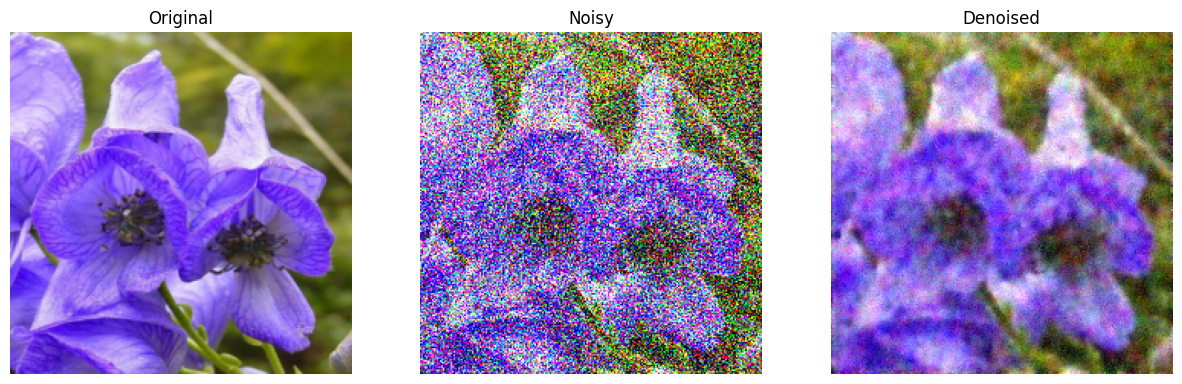

In [51]:
test_data, _ = next(iter(dataloader))
test_data = test_data.to(device)


t = torch.rand(test_data.size(0), 1, 1, 1, device=device)
noisy_data = forward_diffusion(test_data, t, noise_std)


model.eval()
with torch.no_grad():
    predicted_noise = model(noisy_data, t)
    denoised_data = noisy_data - noise_std * predicted_noise * torch.sqrt(t)

original_images = test_data.permute(0, 2, 3, 1).cpu().numpy()
noisy_images = noisy_data.permute(0, 2, 3, 1).cpu().numpy()
denoised_images = (noisy_data - noise_std * predicted_noise * torch.sqrt(t)).permute(0, 2, 3, 1).cpu().numpy()
    

visualize_samples(original_images[0], noisy_images[0], denoised_images[0])
